# Optimization of Hertz NN regression model with Optuna

In [45]:
import optuna
from optuna.trial import TrialState

# Math and Dataframes
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# Machine Learning 
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
from torch import nn
# from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# Others
from datetime import datetime
import os
from pathlib import Path

In [46]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

# update to latex fonts
plt.rcParams.update(tex_fonts)

In [47]:
def hertz(i, E, nu, r):
    a = i/r
    factor = 1 - 0.1 * a - (1/840) * a**2 + (11/15120) * a**3 + (1357/6652800) * a**4
    force = 4/3 * E / (1 - nu**2) * np.sqrt(r)*i**1.5 * factor
    # make nan values zero
    force[np.isnan(force)] = 0
    return force*10**-6

(array([ 614., 1734., 1799., 1573., 1317., 1007.,  852.,  590.,  378.,
         136.]),
 array([0.21350677, 1.17709364, 2.1406805 , 3.10426736, 4.06785422,
        5.03144108, 5.99502794, 6.9586148 , 7.92220166, 8.88578852,
        9.84937538]),
 <BarContainer object of 10 artists>)

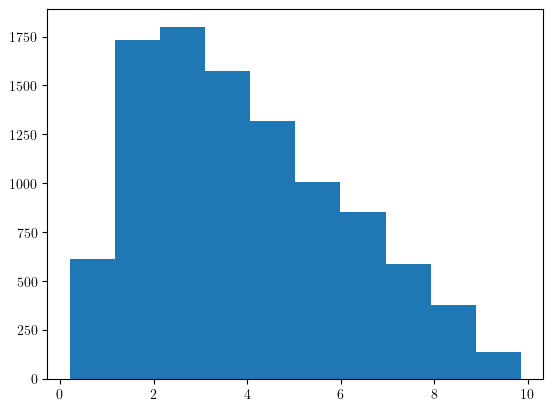

In [48]:
# resolution of the map
res = 200
# random values
size = res * res
size = 10_000
# Seed (if needed)
np.random.seed(42)
# Young's modulus [kPa] - random values following a normal distribution
    #loc: mean/center of distribution
    #scale: std
# E = abs(np.random.normal(loc=2.5, scale=2., size=size)) # !!!!!!!!!!! colocar o abs
# Define a minimum value for a normal distribution, by multiplying lower values by a factor
# while np.any(E < 0.2):
#     E = np.where(E < 0.2, E*10, E) 

# Uniform distribution:
# E = abs(np.random.uniform(low=0.3, high=10., size=size))
E = np.random.triangular(left=0.2, mode=1.8, right=10, size=size)

# Poisson's ratio 
nu = 0.5
# radius of the indenter
r = 1980.0

plt.hist(E, bins=10)

In [49]:
# no contact approach. less points
#linspace(p1, p2, n_pts)
no_contact = np.linspace(-800, 0, 3)

'''DISPLACEMENT VECTORS'''
# xmin, xmax, npts = 0, 250, 50
xmin, xmax, npts = 0, 150, 50

'''Uniformly distributed disp. vectors'''
# indentation depth. more points
contact = np.linspace(xmin, xmax, npts+1)
# approach and withdraw
approach = np.concatenate([no_contact[:-1], contact])
withdraw = np.flip(approach)
ramp = np.concatenate([approach, withdraw])

'''Randomly distributed disp. vectors'''
# Seed (if needed)
np.random.seed(42)

rnd_contact_list = [contact]
for _ in range(size-1):
    aux = np.random.random(npts+1).cumsum()
    aux = (aux-aux.min()) / aux.ptp()     #... .ptp(): peak to peak, i.e., xmax-xmin
    aux = (xmax-xmin)*aux + xmin
    rnd_contact_list.append(aux)
rnd_contact = np.array(rnd_contact_list)
rnd_approach = np.concatenate([np.repeat([no_contact[:-1]], size, axis=0), rnd_contact], axis=1)
rnd_withdraw = np.flip(rnd_approach, axis=1)

# define ramp time
half_cycle = 2 
t_approach = half_cycle*((approach - approach.min(axis=0)) / (approach.max(axis=0) - approach.min(axis=0)))
t_withdraw = half_cycle*((withdraw - withdraw.max(axis=0)) / (withdraw.min(axis=0) - withdraw.max(axis=0)))+max(t_approach)
t = np.concatenate([t_approach, t_withdraw])

In [50]:
# construct dataframe
df = pd.DataFrame()
# 'E' and 'gamma' arrays to list:
df['E'] = E.tolist()
# assigns the displacement array for each 'E' (num of E values = len(df) = size)
df['approach'] = [rnd_approach[app] for app in range(len(df))]
# applies hertz and jkr models to each row (axis= 0(col) or 1(row))
    # x will take the values of each row 
df['f_hertz'] = df.apply(lambda x: hertz(x.approach, x.E, nu, r), axis=1)
df['f_hertz']

C:\Users\luisr\AppData\Local\Temp\ipykernel_13908\3687589619.py:4: RuntimeWarning: invalid value encountered in power
  force = 4/3 * E / (1 - nu**2) * np.sqrt(r)*i**1.5 * factor


0       [0.0, 0.0, 0.0, 0.0011961448981617604, 0.00338...
1       [0.0, 0.0, 0.0, 0.009849339038204478, 0.023186...
2       [0.0, 0.0, 0.0, 0.006166689827643707, 0.016818...
3       [0.0, 0.0, 0.0, 0.0019097329630840666, 0.00887...
4       [0.0, 0.0, 0.0, 0.0019057781820142874, 0.00264...
                              ...                        
9995    [0.0, 0.0, 0.0, 3.5093580130606854e-05, 0.0021...
9996    [0.0, 0.0, 0.0, 0.0004766002782444721, 0.00483...
9997    [0.0, 0.0, 0.0, 0.005189765268538019, 0.009527...
9998    [0.0, 0.0, 0.0, 0.0006737674495825931, 0.00462...
9999    [0.0, 0.0, 0.0, 1.7009832812983926e-05, 0.0007...
Name: f_hertz, Length: 10000, dtype: object

In [51]:
#dataframe with contact-only data
#df_hc: hertz contact
df_hc = pd.DataFrame()
df_hc['approach_contact'] = df['approach'].apply(lambda x: x[x>0]) # Para considerar o 0: x>=0
df_hc['f_hertz_contact'] = df['f_hertz'].apply(lambda x: x[len(no_contact):]) # len(no_contact)-1
df_hc['E_hertz'] = df['E']
#df_hc['appproach_contact'] = df.apply(lambda x: x.approach[x.approach>=0], axis=1)
#check size of disp and force vectors
print(df_hc['approach_contact'][0].shape, df_hc['f_hertz_contact'][0].shape)
for i in range(len(df_hc)):
    # check if there are negative values in 'f_hertz_contact' 
    if (df_hc['f_hertz_contact'][i]<0).any():
        print('Negative values in row', i)
        break

(50,) (50,)


In [52]:
# plot all entries naively
# i: row index; row: data of each row in series format
'''for i, row in df.iterrows():
    #alpha: transparency
    plt.plot(row['approach'], row['f_hertz'], color='blue', alpha=0.1)
#add labels
plt.xlabel('Displacement (nm)')
plt.ylabel('Force (nN)')
# invert x axis
# plt.axis() returns (xmin, xmax, ymin, ymax)
ax = plt.axis()
plt.axis((ax[1],ax[0],ax[2],ax[3]))'''

"for i, row in df.iterrows():\n    #alpha: transparency\n    plt.plot(row['approach'], row['f_hertz'], color='blue', alpha=0.1)\n#add labels\nplt.xlabel('Displacement (nm)')\nplt.ylabel('Force (nN)')\n# invert x axis\n# plt.axis() returns (xmin, xmax, ymin, ymax)\nax = plt.axis()\nplt.axis((ax[1],ax[0],ax[2],ax[3]))"

((7000, 2),
 (1500, 2),
 (1500, 2),
 (7000,),
 array([[array([  1.03838843,   6.66665208,   7.33331245,  13.62566961,
                 15.92451892,  19.80201443,  20.24454998,  25.8990849 ,
                 27.93439902,  29.44282158,  33.93762542,  35.26551455,
                 38.01173766,  39.89236662,  45.84318286,  50.90332175,
                 52.82533965,  55.14649358,  57.01339525,  60.89970777,
                 65.88292359,  71.60585332,  73.29710733,  74.8584095 ,
                 75.75423383,  80.57536857,  81.11523247,  83.69314529,
                 83.72355077,  88.11840871,  92.66835492,  96.87093121,
                101.54629712, 101.69813006, 104.18974314, 106.46051084,
                110.21067477, 115.09381351, 118.36331938, 122.96782247,
                125.76730703, 125.99335756, 131.69341814, 133.73472588,
                136.6931302 , 139.23941508, 142.52211019, 144.45016348,
                147.39276068, 150.        ])                           ,
         array([5

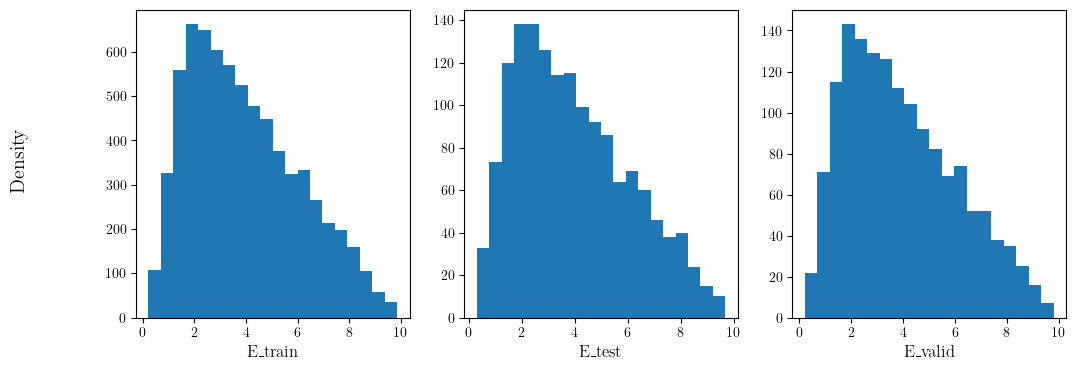

In [53]:
x_hc = np.array(df_hc[['approach_contact', 'f_hertz_contact']])
y_hc = np.array(df_hc['E_hertz'])

test_ratio = 0.15
# (!!!) validation ratio is currently given in relation to the entire dataset (!!!!)
valid_ratio = 0.15 
rnd_state = 42

# Without stratify
#x_train, x_test, y_train, y_test = train_test_split(x_hc, y_hc, test_size=test_ratio, random_state=rnd_state)

#With stratify
bin_count = 100
bins = pd.qcut(y_hc, bin_count, labels=False, duplicates='drop')
x_train, x_test, y_train, y_test = train_test_split(x_hc, y_hc, test_size=test_ratio,
                                                     random_state=rnd_state, stratify = bins)

bins = pd.qcut(y_train, bin_count, labels=False, duplicates='drop')
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=valid_ratio/(1-test_ratio),
                                                       random_state=rnd_state, stratify = bins)

fig, ax = plt.subplots(1,3, figsize=(12,4))
dens = True
xlabel_list_hertz = ['E_train', 'E_test', 'E_valid']
if dens:
    fig.supylabel('Density')
else:
    fig.supylabel('Frequency')
for ix, sp in enumerate(ax):
    sp.set_xlabel(xlabel_list_hertz[ix])
ax[0].hist(y_train, 20)
ax[1].hist(y_test, 20)
ax[2].hist(y_valid, 20)

x_train.shape, x_valid.shape, x_test.shape, y_train.shape, x_train

In [54]:
# Training and test data from np arrays to torch tensor with desired shape
def tensor_input_shape(nparray):
    '''
    Input: nparray - numpy array with two dimensions (n_samples, n_features)
    Output: torch_tensor - pytorch tensor with 3 dimensions (n_samples, n_pts, n_features) 
    '''
    n_samples = len(nparray)
    n_pts = len(nparray[0,0])
    torch_tensor = torch.zeros(size=(n_samples, n_pts, 2))
    for i in range(n_samples):
        aux_nparray = np.hstack((np.array(nparray[i,0]).reshape((n_pts,1)), np.array(nparray[i,1]).reshape((n_pts,1))))
        aux_ttensor = torch.from_numpy(aux_nparray).type(torch.float)
        torch_tensor[i,:,:] = aux_ttensor
    return torch_tensor

x_train_t = tensor_input_shape(x_train)
x_valid_t = tensor_input_shape(x_valid)
x_test_t = tensor_input_shape(x_test)
y_train_t = torch.from_numpy(y_train).type(torch.float).unsqueeze(dim=1)
y_valid_t = torch.from_numpy(y_valid).type(torch.float).unsqueeze(dim=1)
y_test_t = torch.from_numpy(y_test).type(torch.float).unsqueeze(dim=1)

In [55]:
def create_model_dir(timestamp, contact_model: str):

  ''' Second input must be 'hertz' or 'jkr' '''
  
  allowed_models = ['hertz', 'jkr']
  if contact_model not in allowed_models:
    raise ValueError("Input value must be one of %s" % allowed_models)
  model_path = 'model_{}'.format(timestamp)
  parent_dir = 'c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese'
  if contact_model == 'hertz':
    dir = 'Hertz_models'
  elif contact_model == 'jkr':
    dir = 'JKR_models'
  path = os.path.join(parent_dir, dir, model_path)
  # path = os.path.join(initial_wd, dir, model_path)
  os.mkdir(path)
  os.chdir(path)

def error_fn(predict_tensor, label_tensor):
  '''
  INPUTS: * two tensors - true labels and predicts
  OUTPUTS: * scalar - mean relative error (in %) between both tensors
           * list - relative error (%) for each prediction
  '''
  error = abs((label_tensor-predict_tensor)/label_tensor*100).squeeze(dim=1).mean().item()
  error_list = list(abs((label_tensor-predict_tensor)/label_tensor*100).squeeze(dim=1).detach().numpy())
  return error, error_list

In [56]:
class Hertz_Dataset():
  
  def __init__(self,features,labels):
    self.features = features
    self.labels = labels
 
  def __len__(self):
    return len(self.labels)
   
  def __getitem__(self,idx):
    return self.features[idx],self.labels[idx]
  
train_data = Hertz_Dataset(x_train_t, y_train_t)
test_data = Hertz_Dataset(x_test_t, y_test_t)
valid_data = Hertz_Dataset(x_valid_t, y_valid_t)

In [57]:
################ After changing one of the hyperparameters: ########################
### Re-run the cells where the model class and the model_params dict are defined ###
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"

# HYPERPARAMETERS
LEARNING_RATE = 0.001
EPOCHS = 20
BATCH_SIZE = 32

# Size of each layer
HIDDEN_UNITS_1 = 256
HIDDEN_UNITS_2 = 64

ARCHITECTURE = 1

DEVICE

'cuda'

In [58]:
train_loader=DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
test_loader=DataLoader(test_data,batch_size=int(test_ratio*size+1),shuffle=False)
valid_loader=DataLoader(valid_data, batch_size=int(valid_ratio*size+1), shuffle=False)

In [59]:
for i, data in enumerate(train_loader):
  print(data[0].shape)
  print(data[1].shape)
  break

torch.Size([32, 50, 2])
torch.Size([32, 1])


In [60]:
# Define the linear regression model
class Regression_Hertz(nn.Module):
    def __init__(self, input_shape, HIDDEN_UNITS_1, HIDDEN_UNITS_2):
        super(Regression_Hertz, self).__init__()
        input_size = input_shape[0] * input_shape[1]
        self.layers = nn.Sequential(nn.Flatten(),
                                    nn.Linear(input_size, HIDDEN_UNITS_1),
                                    nn.ReLU(),
                                    nn.Linear(HIDDEN_UNITS_1,HIDDEN_UNITS_2),
                                    nn.ReLU(),
                                    nn.Linear(HIDDEN_UNITS_2, 1))
    def forward(self, x):
        out = self.layers(x)
        return out
# Define input shape
input_shape = x_train_t.shape[1:]

# Instantiate the model
torch.manual_seed(42)
model_Hertz = Regression_Hertz(input_shape, HIDDEN_UNITS_1, HIDDEN_UNITS_2).to(DEVICE)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()

# get model_Hertz parameters
model_params = list(model_Hertz.parameters())
model_params[1].shape[0]


256

In [61]:
def train_one_epoch(epoch_index, train_loader, optimizer): # (epoch_index, tb_writer)
    # running_loss = 0.
    # last_loss = 0.
    loss_list = []
    error_list = []
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_Hertz(inputs.to(DEVICE))
        print(outputs)
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels.to(DEVICE))
        # error, _ = error_fn(outputs, labels)
        loss.backward()
        # Adjust learning weights
        optimizer.step()
        # Gather data and report
        loss_list.append(loss.item())
        # error_list.append(error)
        # running_loss += loss.item()  # .item() converts tensor to number
        # print(i, loss.item())
    return loss_list, error_list

In [62]:
def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    # n_layers = trial.suggest_int("n_layers", 2, 3)
    n_layers = 3
    layers = []
    neurons = []
    in_features = input_shape[0] * input_shape[1]
    for i in range(n_layers):
        if i == 0:
            layers.append(nn.Flatten())
            out_features = 256
            # out_features = trial.suggest_categorical("n_units_l{}".format(i), [64, 128, 256])
        elif i == 1:
            out_features = 256
            # out_features = trial.suggest_categorical("n_units_l{}".format(i), [32, 64, 128, 256])
        elif i == 2:
            out_features = 32
            # out_features = trial.suggest_categorical("n_units_l{}".format(i), [16, 32, 64, 128])
        neurons.append(out_features)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.LeakyReLU())
        '''if i == 0 or i == 1:
            p = trial.suggest_float("dropout_l{}".format(i), 0.05, 0.3, step=0.05)
            layers.append(nn.Dropout(p))'''

        in_features = out_features
    layers.append(nn.Linear(in_features, 1))
    # layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers), neurons

In [63]:
losses = []
lr_list = []
epoch_list = []
nl1_list, nl2_list, nl3_list = [], [], []
# BATCH_SIZE_list = []
# n_layers_list = []
def objective(trial):

    torch.manual_seed(42)
    # model_Hertz = Regression_Hertz(input_shape, HIDDEN_UNITS_1, HIDDEN_UNITS_2).to(DEVICE)
    model_Hertz = define_model(trial)[0].to(DEVICE)
    learning_rate = trial.suggest_float("learning_rate", 8e-5, 2e-3, log=True)
    n_epochs = 80
    # n_epochs = trial.suggest_int('n_epochs', 60, 100, step=10)
    # optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    # batch_size = trial.suggest_categorical("batch_size", [16, 32]
    batch_size = 16
    # n_layers = trial.suggest_int("n_layers", 1, 5)
    # n_nodes = trial.suggest_int("n_nodes", 4, 64, log=True)
    train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # loss_fn = nn.HuberLoss()
    optimizer = torch.optim.Adam(model_Hertz.parameters(), 
                            lr=learning_rate)
    lr_list.append(learning_rate)
    # epoch_list.append(n_epochs)
    # nl1_list.append(define_model(trial)[1][0])
    # nl2_list.append(define_model(trial)[1][1])
    # nl3_list.append(define_model(trial)[1][2])
    # BATCH_SIZE_list.append(batch_size)
    for epoch in range(n_epochs):
        model_Hertz.train(True)
        loss_list = []
        error_list = []
        for i, data in enumerate(train_loader):
            # Every data instance is an input + label pair
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model_Hertz(inputs.to(DEVICE))
            # print(f'Outputs: {outputs.mean()}')
            # Compute the loss and its gradients
            loss = loss_fn(outputs, labels.to(DEVICE))
            # error, _ = error_fn(outputs, labels)
            loss.backward()
            loss_list.append(loss)
            # Adjust learning weights
            optimizer.step()
        # Evaluation
        model_Hertz.eval()
        running_vloss = 0.0
        running_verror = 0.0
        verror_list, fts_list, labels_list, predicts_list = [], [], [], []
        with torch.no_grad():
            for i, vdata in enumerate(valid_loader):
                vinputs, vlabels = vdata
                voutputs = model_Hertz(vinputs.to(DEVICE))
                predicts_list.append(voutputs)
                vloss = loss_fn(voutputs, vlabels.to(DEVICE))
                # verror, verror_aux_list = error_fn(voutputs, vlabels)
                running_vloss += vloss
                # running_verror += verror
                # verror_list += verror_aux_list
            loss = running_vloss / (i + 1)
            # print(loss.item())
            # avg_verror = running_verror / (i + 1)
            # print(avg_verror)
        trial.report(loss.item(), epoch)
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return loss.item()

if __name__ == "__main__":
    study_name = "hertz_Huber_LeakyReLU"
    study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2), 
                                study_name=study_name)
    study.optimize(objective, n_trials=100)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    # Retrieve the losses from each trial
    losses = [trial.value for trial in study.trials]

    # Convert the losses to a NumPy array
    losses_array = np.array(losses)
    epoch_array = np.array(epoch_list)
    nl1_array = np.array(nl1_list)
    nl2_array = np.array(nl2_list)
    nl3_array = np.array(nl3_list)
    lr_array = np.array(lr_list)
    # BATCH_SIZE_array = np.array(BATCH_SIZE_list)

    # Save the losses as a NumPy file
    np.save("losses.npy", losses_array)
    np.save("lr.npy", lr_array)
    # np.save("epoch.npy", epoch_array)
    # np.save("nl1.npy", nl1_array)
    # np.save("nl2.npy", nl2_array)
    # np.save("nl3.npy", nl3_array)
    # np.save("BATCH_SIZE.npy", BATCH_SIZE_array)


[I 2023-06-09 19:11:38,381] A new study created in memory with name: hertz_Huber_LeakyReLU


[I 2023-06-09 19:13:17,249] Trial 0 finished with value: 0.001060820766724646 and parameters: {'learning_rate': 0.0008462923348053897}. Best is trial 0 with value: 0.001060820766724646.
[I 2023-06-09 19:14:55,138] Trial 1 finished with value: 0.0022070736158639193 and parameters: {'learning_rate': 0.00014128237500567233}. Best is trial 0 with value: 0.001060820766724646.
[I 2023-06-09 19:16:32,956] Trial 2 finished with value: 0.0013248664326965809 and parameters: {'learning_rate': 0.0006567296926943176}. Best is trial 0 with value: 0.001060820766724646.
[I 2023-06-09 19:18:02,760] Trial 3 finished with value: 0.0008113170624710619 and parameters: {'learning_rate': 0.0007147266922542866}. Best is trial 3 with value: 0.0008113170624710619.
[I 2023-06-09 19:19:21,620] Trial 4 finished with value: 0.00816664844751358 and parameters: {'learning_rate': 0.00033424531940605125}. Best is trial 3 with value: 0.0008113170624710619.
[I 2023-06-09 19:19:25,807] Trial 5 pruned. 
[I 2023-06-09 19:19

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  95
  Number of complete trials:  5
Best trial:
  Value:  0.0008113170624710619
  Params: 
    learning_rate: 0.0007147266922542866


In [64]:
study.best_trial

FrozenTrial(number=3, values=[0.0008113170624710619], datetime_start=datetime.datetime(2023, 6, 9, 19, 16, 32, 957478), datetime_complete=datetime.datetime(2023, 6, 9, 19, 18, 2, 760580), params={'learning_rate': 0.0007147266922542866}, distributions={'learning_rate': FloatDistribution(high=0.002, log=True, low=8e-05, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.04097307473421097, 1: 0.09588663280010223, 2: 0.014600295573472977, 3: 0.005430436227470636, 4: 0.009710155427455902, 5: 0.016627321019768715, 6: 0.019039614126086235, 7: 0.027309361845254898, 8: 0.007550874724984169, 9: 0.01060210820287466, 10: 0.028680521994829178, 11: 0.004457881674170494, 12: 0.01022147387266159, 13: 0.010062102228403091, 14: 0.003963250666856766, 15: 0.031752411276102066, 16: 0.002852083183825016, 17: 0.004158950876444578, 18: 0.002545578172430396, 19: 0.0028311728965491056, 20: 0.011926617473363876, 21: 0.00782278086990118, 22: 0.0868893638253212, 23: 0.04112496227025986, 24: 0.0

In [65]:
losses_array

array([0.00106082, 0.00220707, 0.00132487, 0.00081132, 0.00816665,
       0.0292922 , 0.02937042, 0.06270446, 0.03356687, 0.10644777,
       0.01476322, 0.01000695, 0.01468199, 0.0081203 , 0.0016688 ,
       0.13615263, 0.00690434, 0.05032717, 0.01915853, 0.03320339,
       0.00615489, 0.0191041 , 0.01480413, 0.02549207, 0.03335163,
       0.0100749 , 0.02741095, 0.01479084, 0.05588803, 0.02074639,
       0.01090765, 0.07914276, 0.03908939, 0.01636979, 0.02803308,
       0.04560414, 0.00705019, 0.01942293, 0.01622711, 0.03691093,
       0.01488997, 0.03283856, 0.08066823, 0.02994043, 0.02022811,
       0.00978903, 0.02705878, 0.04576854, 0.00195128, 0.04399893,
       0.01361757, 0.02850888, 0.08775533, 0.00407787, 0.00439126,
       0.00791156, 0.02310325, 0.0042605 , 0.3330164 , 0.00108534,
       0.00314386, 0.01614095, 0.03747291, 0.04054297, 0.05160863,
       0.04319647, 0.00089129, 0.01350618, 0.03133054, 0.01465508,
       0.10469509, 0.02208679, 0.00318352, 0.00319092, 0.04444

In [66]:
study.trials

[FrozenTrial(number=0, values=[0.001060820766724646], datetime_start=datetime.datetime(2023, 6, 9, 19, 11, 38, 384689), datetime_complete=datetime.datetime(2023, 6, 9, 19, 13, 17, 248420), params={'learning_rate': 0.0008462923348053897}, distributions={'learning_rate': FloatDistribution(high=0.002, log=True, low=8e-05, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.034810591489076614, 1: 0.025302955880761147, 2: 0.027889516204595566, 3: 0.006409112364053726, 4: 0.06674312055110931, 5: 0.014689652249217033, 6: 0.030774181708693504, 7: 0.017077406868338585, 8: 0.02041640691459179, 9: 0.021519998088479042, 10: 0.017688343301415443, 11: 0.0028915011789649725, 12: 0.009019116871058941, 13: 0.02318742871284485, 14: 0.006086517125368118, 15: 0.02428591437637806, 16: 0.010586586780846119, 17: 0.00523378187790513, 18: 0.04672304168343544, 19: 0.007324636448174715, 20: 0.00406042393296957, 21: 0.002515291329473257, 22: 0.010368343442678452, 23: 0.3057764172554016, 24: 0.0